# impot librarys

In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV

import lightgbm as lgb
from catboost import CatBoostRegressor

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = 500

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [36]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# train and test

In [2]:
train = pd.read_csv('../input/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('../input/test.csv', parse_dates=['first_active_month'])
# submission = pd.read_csv('../input/sample_submission.csv')

In [3]:
e = pd.read_excel('../input/Data_Dictionary.xlsx', sheet_name='train')
e

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [4]:
train['feature_1'] = train['feature_1'].astype('category')
train['feature_2'] = train['feature_2'].astype('category')
train['feature_3'] = train['feature_3'].astype('category')

In [5]:
test['feature_1'] = test['feature_1'].astype('category')
test['feature_2'] = test['feature_2'].astype('category')
test['feature_3'] = test['feature_3'].astype('category')

## visualization

### categorical features

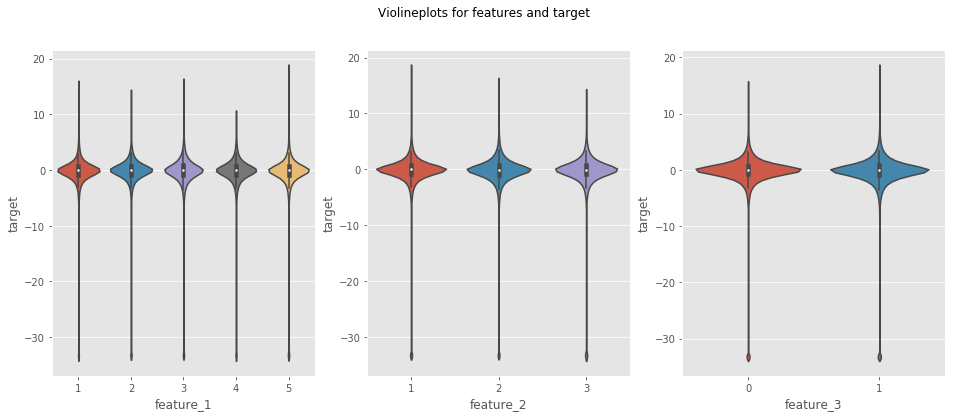

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Violineplots for features and target')
sns.violinplot(x="feature_1", y="target", data=train, ax=ax[0], title='feature_1')
sns.violinplot(x="feature_2", y="target", data=train, ax=ax[1], title='feature_2')
sns.violinplot(x="feature_3", y="target", data=train, ax=ax[2], title='feature_3')
plt.show()

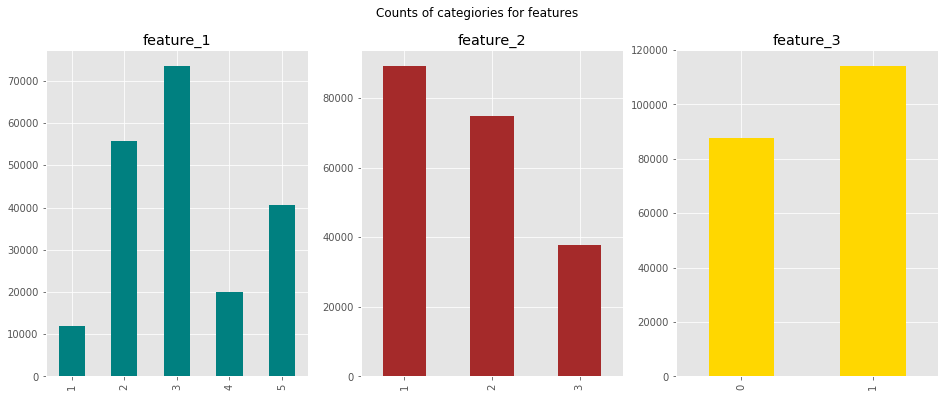

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='feature_1')
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='feature_2')
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='gold', title='feature_3')
plt.suptitle('Counts of categiories for features')
plt.show()

### date

In [8]:
d1 = train['first_active_month'].value_counts().sort_index()
d2 = test['first_active_month'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Counts of first active",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

### target

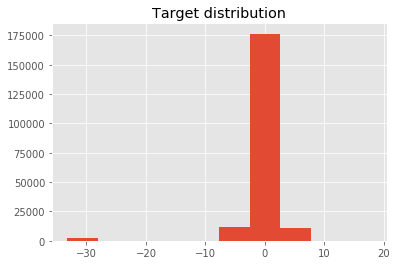

In [9]:
plt.hist(train['target'])
plt.title('Target distribution')
plt.show()

In [10]:
print('There are {0} samples with target lower than -30.'.format(train.loc[train.target < -20].shape[0]))

There are 2207 samples with target lower than -30.


### feature engineering

In [11]:
test.loc[test['first_active_month'].isna(), 'first_active_month'] = test.loc[(test['feature_1'] == 5) & (test['feature_2'] == 2) & (test['feature_3'] == 1), 'first_active_month'].min()

In [12]:
max_date = train['first_active_month'].dt.date.max()
def process_main(df):
    date_parts = ["year", "weekday", "month"]
    for part in date_parts:
        part_col = 'first_active_month' + "_" + part
        df[part_col] = getattr(df['first_active_month'].dt, part).astype(int)
            
    df['elapsed_time'] = (max_date - df['first_active_month'].dt.date).dt.days
    
    return df

In [13]:
train = process_main(train)
test = process_main(test)

# historical transactions

In [14]:
historical_transactions = pd.read_csv('../input/historical_transactions.csv')

In [15]:
e = pd.read_excel('../input/Data_Dictionary.xlsx', sheet_name='history')
e

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [16]:
print(f'{historical_transactions.shape[0]} samples')
historical_transactions.head()

29112361 samples


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


## authorized flag

In [17]:
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].apply(lambda x: np.where(x == 'Y', 1, 0))

At average 91.3545% transactions are authorized


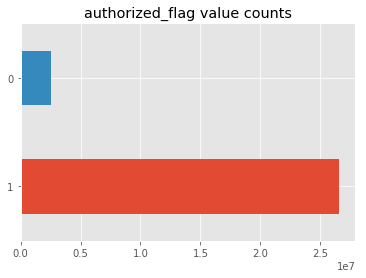

In [18]:
print(f"At average {historical_transactions['authorized_flag'].mean() * 100:.4f}% transactions are authorized")
historical_transactions['authorized_flag'].value_counts().plot(kind='barh', title='authorized_flag value counts')
plt.show()

In [19]:
autorized_card_rate = historical_transactions.groupby(['card_id'])['authorized_flag'].mean().sort_values()
autorized_card_rate.head()

card_id
C_ID_744d26ea32    0.030488
C_ID_bb8dd137c9    0.037037
C_ID_e56202cd39    0.042105
C_ID_4feacff118    0.050000
C_ID_c27b4f80f7    0.054545
Name: authorized_flag, dtype: float64

In [20]:
autorized_card_rate.tail()

card_id
C_ID_d048b7cc60    1.0
C_ID_4e45fcdb43    1.0
C_ID_9f3ee1305e    1.0
C_ID_1b52a3e21b    1.0
C_ID_d3c3d988d5    1.0
Name: authorized_flag, dtype: float64

## installments

In [21]:
historical_transactions['installments'].value_counts()

 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64

In [22]:
historical_transactions.groupby(['installments'])['authorized_flag'].mean()

installments
-1      0.885692
 0      0.928032
 1      0.907024
 2      0.884020
 3      0.862254
 4      0.819903
 5      0.809183
 6      0.779732
 7      0.693196
 8      0.692439
 9      0.663721
 10     0.702021
 11     0.660241
 12     0.653694
 999    0.031915
Name: authorized_flag, dtype: float64

In [23]:
historical_transactions['installments'] = historical_transactions['installments'].astype('category')

In [24]:
historical_transactions['purchase_date'] = pd.to_datetime(historical_transactions['purchase_date'])

## purchase amount

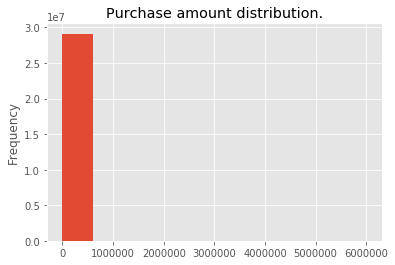

In [26]:
plt.title('Purchase amount distribution.')
historical_transactions['purchase_amount'].plot(kind='hist')
plt.show()                       

In [27]:
for i in [-1, 0]:
    n = historical_transactions.loc[historical_transactions['purchase_amount'] < i].shape[0]
    print(f"There are {n} transactions with purchase_amount less than {i}.")
for i in [0, 10, 100]:
    n = historical_transactions.loc[historical_transactions['purchase_amount'] > i].shape[0]
    print(f"There are {n} transactions with purchase_amount more than {i}.")

There are 0 transactions with purchase_amount less than -1.
There are 28036884 transactions with purchase_amount less than 0.
There are 1075467 transactions with purchase_amount more than 0.
There are 14924 transactions with purchase_amount more than 10.
There are 1183 transactions with purchase_amount more than 100.


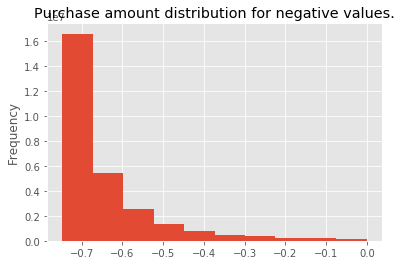

In [28]:
plt.title('Purchase amount distribution for negative values.');
historical_transactions.loc[historical_transactions['purchase_amount'] < 0, 'purchase_amount'].plot(kind='hist')
plt.show()

## categories

In [29]:
map_dict = {'Y': 0, 'N': 1}
historical_transactions['category_1'] = historical_transactions['category_1'].apply(lambda x: map_dict[x])
historical_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

purchase_amount                        authorized_flag          
                      mean          std     count            mean       std
category_1                                                                 
0                -0.419327    22.087594   2084029        0.748578  0.433830
1                 0.071540  1166.016045  27028332        0.926265  0.261339

In [30]:
historical_transactions.groupby(['category_2']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

purchase_amount                        authorized_flag          
                      mean          std     count            mean       std
category_2                                                                 
1.0               0.149570  1548.714128  15177199        0.927505  0.259306
2.0              -0.165690    89.285770   1026535        0.906225  0.291515
3.0               0.180375   210.616100   3911795        0.918857  0.273055
4.0              -0.158951   141.945606   2618053        0.927634  0.259094
5.0              -0.104457   162.428785   3725915        0.934260  0.247826

In [31]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
historical_transactions['category_3'] = historical_transactions['category_3'].apply(lambda x: map_dict[str(x)])
historical_transactions.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

purchase_amount                        authorized_flag          
                      mean          std     count            mean       std
category_3                                                                 
0                 0.361926  1541.485188  15411747        0.928032  0.258436
1                -0.404556   104.062692  11677522        0.907024  0.290399
2                 0.106023    24.047655   1844933        0.836498  0.369824
3                 0.058447     2.191567    178159        0.885692  0.318186

In [32]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {historical_transactions[col].nunique()} unique values in {col}.")

There are 308 unique values in city_id.
There are 327 unique values in merchant_category_id.
There are 326311 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.


## feature engineering

In [38]:
def aggregate_historical_transactions(trans, prefix):
    # more features from this kernel: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699
    trans['purchase_month'] = trans['purchase_date'].dt.month
#     trans['year'] = trans['purchase_date'].dt.year
#     trans['weekofyear'] = trans['purchase_date'].dt.weekofyear
#     trans['month'] = trans['purchase_date'].dt.month
#     trans['dayofweek'] = trans['purchase_date'].dt.dayofweek
#     trans['weekend'] = (trans.purchase_date.dt.weekday >=5).astype(int)
#     trans['hour'] = trans['purchase_date'].dt.hour
    trans['month_diff'] = ((datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']
    trans['installments'] = trans['installments'].astype(int)

    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']). \
                                        astype(np.int64) * 1e-9
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
        'month_diff': ['min', 'max', 'mean']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [34]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])
    history['installments'] = history['installments'].astype(int)
    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group = aggregate_per_month(historical_transactions) 

In [39]:
del d1, d2, autorized_card_rate
gc.collect()
historical_transactions = reduce_mem_usage(historical_transactions)
history = aggregate_historical_transactions(historical_transactions, prefix='hist_')
history = reduce_mem_usage(history)
gc.collect()

Mem. usage decreased to 1193.84 Mb (14.0% reduction)
Mem. usage decreased to 35.39 Mb (68.2% reduction)


402

In [40]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')
del history

In [41]:
del historical_transactions
gc.collect()

44

# new merchant transactions

In [42]:
new_merchant_transactions = pd.read_csv('../input/new_merchant_transactions.csv')

In [43]:
e = pd.read_excel('../input/Data_Dictionary.xlsx', sheet_name='new_merchant_period')
e

,new_merchant_period.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [44]:
print(f'{new_merchant_transactions.shape[0]} samples')
new_merchant_transactions.head()

1963031 samples in data


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


## authorized flag

In [45]:
new_merchant_transactions['authorized_flag'] = new_merchant_transactions['authorized_flag'].apply(lambda x: np.where(x == 'Y', 1, 0))

At average 100.0000% transactions are authorized


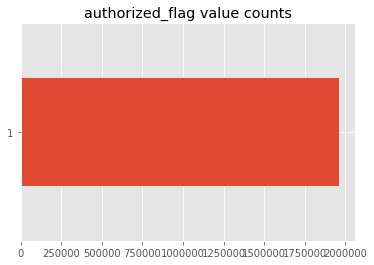

In [46]:
print(f"At average {new_merchant_transactions['authorized_flag'].mean() * 100:.4f}% transactions are authorized")
new_merchant_transactions['authorized_flag'].value_counts().plot(kind='barh', title='authorized_flag value counts');

## purchase amount

In [47]:
card_total_purchase = new_merchant_transactions.groupby(['card_id'])['purchase_amount'].sum().sort_values()
card_total_purchase.head()

card_id
C_ID_b7ebee6539   -70.813489
C_ID_8946508722   -63.907274
C_ID_c729288535   -61.042650
C_ID_6cef1dba4b   -60.780407
C_ID_0e4f6af077   -60.017000
Name: purchase_amount, dtype: float64

In [48]:
card_total_purchase.tail()

card_id
C_ID_72613043cf    109.086210
C_ID_01314ceccf    113.317420
C_ID_a9435eee72    145.168997
C_ID_a289e7edd4    172.182653
C_ID_ca850ecf25    263.157498
Name: purchase_amount, dtype: float64

## installments

In [50]:
new_merchant_transactions['installments'].value_counts()

 0      922244
 1      836178
-1       55922
 2       54729
 3       44750
 4       14815
 6       10389
 5        9296
 10       8899
 12       2850
 8        1555
 7         863
 9         478
 11         61
 999         2
Name: installments, dtype: int64

In [51]:
new_merchant_transactions.groupby(['installments'])['purchase_amount'].sum()

installments
-1        1903.176718
 0     -581948.746520
 1     -507130.345871
 2      -21592.186709
 3       -6669.938153
 4        3212.909351
 5        2641.835005
 6        6994.802878
 7         522.470989
 8        1927.359352
 9         958.387496
 10      13864.551233
 11        117.734959
 12       3627.758765
 999         1.005048
Name: purchase_amount, dtype: float64

In [52]:
new_merchant_transactions['installments'] = new_merchant_transactions['installments'].astype('category')

## purchase amount

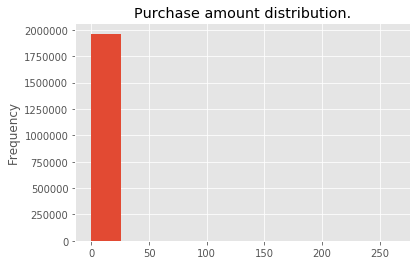

In [53]:
plt.title('Purchase amount distribution.');
new_merchant_transactions['purchase_amount'].plot(kind='hist');

In [54]:
for i in [-1, 0]:
    n = new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] < i].shape[0]
    print(f"There are {n} transactions with purchase_amount less than {i}.")
for i in [0, 10, 100]:
    n = new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] > i].shape[0]
    print(f"There are {n} transactions with purchase_amount more than {i}.")

There are 0 transactions with purchase_amount less than -1.
There are 1877357 transactions with purchase_amount less than 0.
There are 85674 transactions with purchase_amount more than 0.
There are 996 transactions with purchase_amount more than 10.
There are 2 transactions with purchase_amount more than 100.


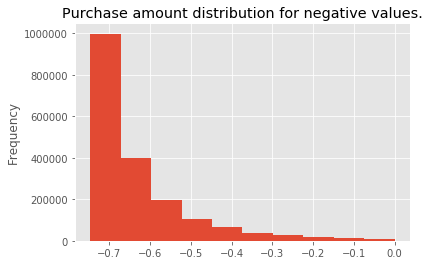

In [55]:
plt.title('Purchase amount distribution for negative values.');
new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] < 0, 'purchase_amount'].plot(kind='hist');

## categories

In [57]:
map_dict = {'Y': 0, 'N': 1}
new_merchant_transactions['category_1'] = new_merchant_transactions['category_1'].apply(lambda x: map_dict[x])
new_merchant_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                   
                      mean       std    count
category_1                                   
0                -0.218671  1.481696    63096
1                -0.562004  0.648799  1899935

In [58]:
new_merchant_transactions.groupby(['category_2']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                   
                      mean       std    count
category_2                                   
1.0              -0.569242  0.673693  1058242
2.0              -0.555640  0.542029    65663
3.0              -0.550852  0.612882   289525
4.0              -0.557578  0.600636   178590
5.0              -0.549015  0.654138   259266

In [59]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
new_merchant_transactions['category_3'] = new_merchant_transactions['category_3'].apply(lambda x: map_dict[str(x)])
new_merchant_transactions.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                  
                      mean       std   count
category_3                                  
0                -0.631014  0.268039  922244
1                -0.606486  0.443664  836178
2                 0.037708  1.787946  148687
3                 0.034033  1.692377   55922

In [60]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {new_merchant_transactions[col].nunique()} unique values in {col}.")

There are 308 unique values in city_id.
There are 314 unique values in merchant_category_id.
There are 226129 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.


In [61]:
new_merchant_transactions['purchase_date'] = pd.to_datetime(new_merchant_transactions['purchase_date'])

## feature engineering

In [64]:
def aggregate_historical_transactions(trans, prefix):
    # more features from this kernel: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699
    trans['purchase_month'] = trans['purchase_date'].dt.month
    trans['year'] = trans['purchase_date'].dt.year
    trans['weekofyear'] = trans['purchase_date'].dt.weekofyear
    trans['month'] = trans['purchase_date'].dt.month
    trans['dayofweek'] = trans['purchase_date'].dt.dayofweek
    trans['weekend'] = (trans.purchase_date.dt.weekday >=5).astype(int)
    trans['hour'] = trans['purchase_date'].dt.hour
    trans['installments'] = trans['installments'].astype(int)
    trans['month_diff'] = ((datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']

    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9
    trans['installments'] = trans['installments'].astype(int)
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [65]:
gc.collect()
new_transactions = reduce_mem_usage(new_merchant_transactions)
history = aggregate_historical_transactions(new_merchant_transactions, prefix='new')
history = reduce_mem_usage(history)
del new_merchant_transactions
gc.collect()

train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')
del history
gc.collect()

train = pd.merge(train, final_group, on='card_id')
test = pd.merge(test, final_group, on='card_id')
gc.collect()
del final_group

Mem. usage decreased to 89.86 Mb (52.9% reduction)
Mem. usage decreased to 24.34 Mb (65.2% reduction)


# merchants

In [66]:
merchants = pd.read_csv('../input/merchants.csv')

In [67]:
e = pd.read_excel('../input/Data_Dictionary.xlsx', sheet_name='merchant')
e

,merchants.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,merchant_id,Unique merchant identifier
3,merchant_group_id,Merchant group (anonymized )
4,merchant_category_id,Unique identifier for merchant category (anony...
5,subsector_id,Merchant category group (anonymized )
6,numerical_1,anonymized measure
7,numerical_2,anonymized measure
8,category_1,anonymized category
9,most_recent_sales_range,Range of revenue (monetary units) in last acti...


In [68]:
print(f'{merchants.shape[0]} merchants')
merchants.head()

334696 merchants in data


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [69]:
map_dict = {'Y': 0, 'N': 1}
merchants['category_1'] = merchants['category_1'].apply(lambda x: map_dict[x])
merchants.loc[merchants['category_2'].isnull(), 'category_2'] = 0
merchants['category_4'] = merchants['category_4'].apply(lambda x: map_dict[x])

In [71]:
merchants['merchant_category_id'].nunique(), merchants['merchant_group_id'].nunique()

(324, 109391)

## numerical_1

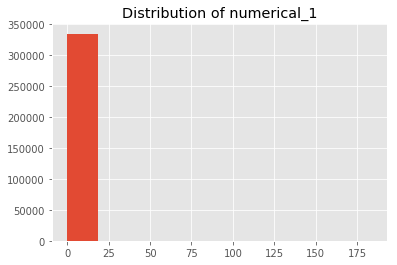

In [72]:
plt.hist(merchants['numerical_1']);
plt.title('Distribution of numerical_1');

In [73]:
np.percentile(merchants['numerical_1'], 95)

0.09125291

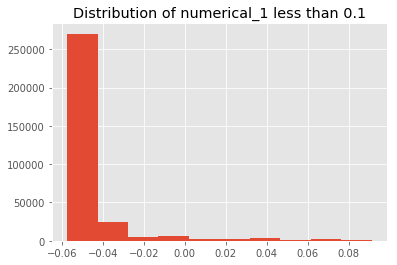

In [74]:
plt.hist(merchants.loc[merchants['numerical_1'] < 0.1, 'numerical_1']);
plt.title('Distribution of numerical_1 less than 0.1');

In [75]:
min_n1 = merchants['numerical_1'].min()
_ = sum(merchants['numerical_1'] == min_n1) / merchants['numerical_1'].shape[0]
print(f'{_ * 100:.4f}% of values in numerical_1 are equal to {min_n1}')

68.3570% of values in numerical_1 are equal to -0.05747065


## numerical_2

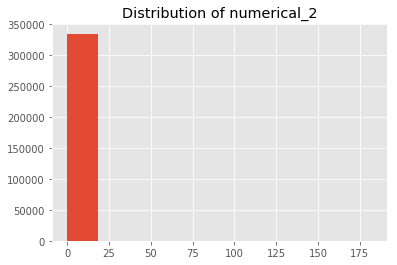

In [76]:
plt.hist(merchants['numerical_2']);
plt.title('Distribution of numerical_2');

68.3570% of values in numerical_1 are equal to -0.05747065


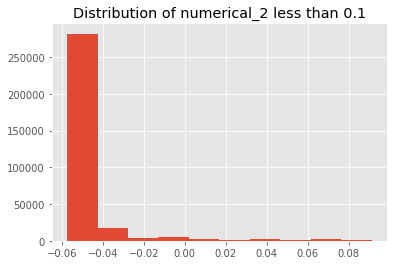

In [78]:
plt.hist(merchants.loc[merchants['numerical_2'] < 0.1, 'numerical_2']);
plt.title('Distribution of numerical_2 less than 0.1');
min_n1 = merchants['numerical_1'].min()
_ = sum(merchants['numerical_1'] == min_n1) / merchants['numerical_1'].shape[0]
print(f'{_ * 100:.4f}% of values in numerical_1 are equal to {min_n1}')

In [79]:
(merchants['numerical_1'] != merchants['numerical_2']).sum() / merchants.shape[0]

0.10056289886942181

## most  recent sales range

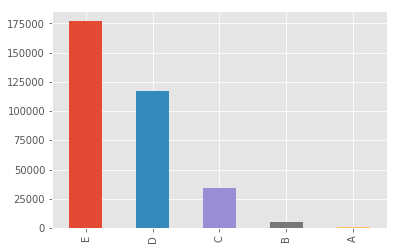

In [80]:
merchants['most_recent_sales_range'].value_counts().plot('bar');

In [81]:
d = merchants['most_recent_sales_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_sales_range')['numerical_1'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), go.Scatter(x=e.index, y=e.values, name='mean numerical_1', yaxis='y2')]
layout = go.Layout(dict(title = "Counts of values in categories of most_recent_sales_range",
                        xaxis = dict(title = 'most_recent_sales_range'),
                        yaxis = dict(title = 'Counts'),
                        yaxis2=dict(title='mean numerical_1', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))

## most recent purchases range

In [82]:
d = merchants['most_recent_purchases_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_purchases_range')['numerical_1'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), go.Scatter(x=e.index, y=e.values, name='mean numerical_1', yaxis='y2')]
layout = go.Layout(dict(title = "Counts of values in categories of most_recent_purchases_range",
                        xaxis = dict(title = 'most_recent_purchases_range'),
                        yaxis = dict(title = 'Counts'),
                        yaxis2=dict(title='mean numerical_1', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))

## avg sales lag

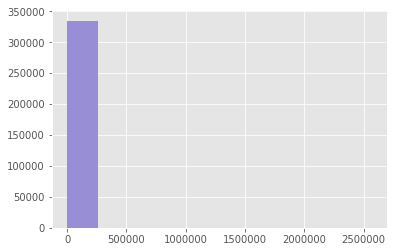

In [83]:
plt.hist(merchants['avg_sales_lag3'].fillna(0));
plt.hist(merchants['avg_sales_lag6'].fillna(0));
plt.hist(merchants['avg_sales_lag12'].fillna(0));

In [84]:
for col in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
    print(f'Max value of {col} is {merchants[col].max()}')
    print(f'Min value of {col} is {merchants[col].min()}')

Max value of avg_sales_lag3 is 851844.64
Min value of avg_sales_lag3 is -82.13
Max value of avg_sales_lag6 is 1513959.0
Min value of avg_sales_lag6 is -82.13
Max value of avg_sales_lag12 is 2567408.0
Min value of avg_sales_lag12 is -82.13


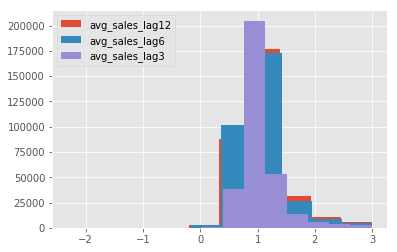

In [85]:
plt.hist(merchants.loc[(merchants['avg_sales_lag12'] < 3) & (merchants['avg_sales_lag12'] > -10), 'avg_sales_lag12'].fillna(0), label='avg_sales_lag12');
plt.hist(merchants.loc[(merchants['avg_sales_lag6'] < 3) & (merchants['avg_sales_lag6'] > -10), 'avg_sales_lag6'].fillna(0), label='avg_sales_lag6');
plt.hist(merchants.loc[(merchants['avg_sales_lag3'] < 3) & (merchants['avg_sales_lag3'] > -10), 'avg_sales_lag3'].fillna(0), label='avg_sales_lag3');
plt.legend();

## avg purchases lag

In [86]:
merchants['avg_purchases_lag3'].nlargest()

10                inf
11                inf
12                inf
235      6.185133e+04
13168    1.730000e+03
Name: avg_purchases_lag3, dtype: float64

In [87]:
merchants.loc[merchants['avg_purchases_lag3'] == np.inf, 'avg_purchases_lag3'] = 6000
merchants.loc[merchants['avg_purchases_lag6'] == np.inf, 'avg_purchases_lag6'] = 6000
merchants.loc[merchants['avg_purchases_lag12'] == np.inf, 'avg_purchases_lag12'] = 6000

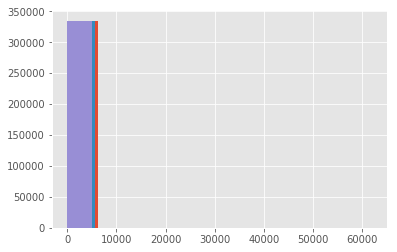

In [88]:
plt.hist(merchants['avg_purchases_lag3'].fillna(0));
plt.hist(merchants['avg_purchases_lag6'].fillna(0));
plt.hist(merchants['avg_purchases_lag12'].fillna(0));

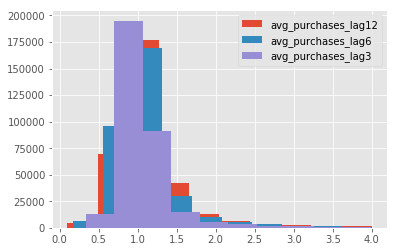

In [89]:
plt.hist(merchants.loc[(merchants['avg_purchases_lag12'] < 4), 'avg_purchases_lag12'].fillna(0), label='avg_purchases_lag12');
plt.hist(merchants.loc[(merchants['avg_purchases_lag6'] < 4), 'avg_purchases_lag6'].fillna(0), label='avg_purchases_lag6');
plt.hist(merchants.loc[(merchants['avg_purchases_lag3'] < 4), 'avg_purchases_lag3'].fillna(0), label='avg_purchases_lag3');
plt.legend();

# Modeling

## processing data

In [90]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_time,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_1.0_sum,hist_category_2_2.0_mean,hist_category_2_2.0_sum,hist_category_2_3.0_mean,hist_category_2_3.0_sum,hist_category_2_4.0_mean,hist_category_2_4.0_sum,hist_category_2_5.0_mean,hist_category_2_5.0_sum,hist_category_3_1_sum,hist_category_3_1_mean,hist_category_3_2_sum,hist_category_3_2_mean,hist_category_3_3_sum,hist_category_3_3_mean,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_min,hist_month_lag_max,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,hist_month_diff_min,hist_month_diff_max,hist_month_diff_mean,newtransactions_count,newcategory_1_sum,newcategory_1_mean,newcategory_2_1.0_mean,newcategory_2_1.0_sum,newcategory_2_2.0_mean,newcategory_2_2.0_sum,newcategory_2_3.0_mean,newcategory_2_3.0_sum,newcategory_2_4.0_mean,newcategory_2_4.0_sum,newcategory_2_5.0_mean,newcategory_2_5.0_sum,newcategory_3_1_sum,newcategory_3_1_mean,newcategory_3_2_sum,newcategory_3_2_mean,newcategory_3_3_sum,newcategory_3_3_mean,newmerchant_id_nunique,newpurchase_amount_sum,newpurchase_amount_mean,newpurchase_amount_max,newpurchase_amount_min,newpurchase_amount_std,newinstallments_sum,newinstallments_mean,newinstallments_max,newinstallments_min,newinstallments_std,newpurchase_month_mean,newpurchase_month_max,newpurchase_month_min,newpurchase_month_std,newpurchase_date_ptp,newpurchase_date_max,newpurchase_date_min,newmonth_lag_min,newmonth_lag_max,newmerchant_category_id_nunique,newstate_id_nunique,newsubsector_id_nunique,newcity_id_nunique,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,3,6,245,260,247.0,0.950195,260.0,1.000000,0.988281,257.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.011536,3.0,4.0,0.015381,0.0,0.000000,0,0.000000,94,-165.968735,-0.638341,2.258394,-0.739258,0.212139,4,0.015381,1,0,0.123291,8.054688,12,1,3.474609,20977988.0,1.519551e+09,1.498573e+09,-8,0,41,3,21,7,9,11,10.000000,23.0,23.0,1.000000,1.000000,23.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,23.0,-13.242188,-0.575684,-0.296143,-0.724609,0.135742,0.0,0.000000,0.0,0.0,0.000000,3.478516,4.0,3.0,0.510742,4742309.0,1.525001e+09,1.520259e+09,1.0,2.0,14.0,1.0,10.0,3.0,-4.000000,2.738613,28.888889,17.244162,-18.440971,10.472169,-0.650518,0.049922,-0.732686,0.008797,-0.158815,0.916015,0.109641,0.117152,28.888889,17.244162,0.444444,0.726483,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,6,1,396,350,339.0,0.968750,319.0,0.911621,0.911621,319.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,276.0,0.788574,72.0,0.205688,2,0.005714,142,-210.006332,-0.600018,4.630300,-0.742188,0.384967,543,1.551758,10,-1,1.510742,6.218750,12,1,3.847656,33717688.0,1.517438e+

In [91]:
for col in train.columns:
    if train[col].isna().any():
        train[col] = train[col].fillna(0)

In [92]:
for col in test.columns:
    if test[col].isna().any():
        test[col] = test[col].fillna(0)

In [93]:
y = train['target']

In [96]:
col_not_to_use = ['first_active_month', 'card_id', 'target']
col_to_use = [c for c in train.columns if c not in col_not_to_use]

In [97]:
# for col in col_to_drop:
#     if col in train.columns:
#         train.drop([col], axis=1, inplace=True)
#     if col in test.columns:
#         test.drop([col], axis=1, inplace=True)

In [98]:
train = train[col_to_use]
test = test[col_to_use]

In [99]:
train['feature_3'] = train['feature_3'].astype(int)
test['feature_3'] = test['feature_3'].astype(int)

In [100]:
categorical_feats = ['feature_1', 'feature_2']

for col in categorical_feats:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [101]:
train.head()

,feature_1,feature_2,feature_3,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_time,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_1.0_sum,hist_category_2_2.0_mean,hist_category_2_2.0_sum,hist_category_2_3.0_mean,hist_category_2_3.0_sum,hist_category_2_4.0_mean,hist_category_2_4.0_sum,hist_category_2_5.0_mean,hist_category_2_5.0_sum,hist_category_3_1_sum,hist_category_3_1_mean,hist_category_3_2_sum,hist_category_3_2_mean,hist_category_3_3_sum,hist_category_3_3_mean,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_min,hist_month_lag_max,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,hist_month_diff_min,hist_month_diff_max,hist_month_diff_mean,newtransactions_count,newcategory_1_sum,newcategory_1_mean,newcategory_2_1.0_mean,newcategory_2_1.0_sum,newcategory_2_2.0_mean,newcategory_2_2.0_sum,newcategory_2_3.0_mean,newcategory_2_3.0_sum,newcategory_2_4.0_mean,newcategory_2_4.0_sum,newcategory_2_5.0_mean,newcategory_2_5.0_sum,newcategory_3_1_sum,newcategory_3_1_mean,newcategory_3_2_sum,newcategory_3_2_mean,newcategory_3_3_sum,newcategory_3_3_mean,newmerchant_id_nunique,newpurchase_amount_sum,newpurchase_amount_mean,newpurchase_amount_max,newpurchase_amount_min,newpurchase_amount_std,newinstallments_sum,newinstallments_mean,newinstallments_max,newinstallments_min,newinstallments_std,newpurchase_month_mean,newpurchase_month_max,newpurchase_month_min,newpurchase_month_std,newpurchase_date_ptp,newpurchase_date_max,newpurchase_date_min,newmonth_lag_min,newmonth_lag_max,newmerchant_category_id_nunique,newstate_id_nunique,newsubsector_id_nunique,newcity_id_nunique,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,4,1,1,2017,3,6,245,260,247.0,0.950195,260.0,1.000000,0.988281,257.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.011536,3.0,4.0,0.015381,0.0,0.000000,0,0.000000,94,-165.968735,-0.638341,2.258394,-0.739258,0.212139,4,0.015381,1,0,0.123291,8.054688,12,1,3.474609,20977988.0,1.519551e+09,1.498573e+09,-8,0,41,3,21,7,9,11,10.000000,23.0,23.0,1.000000,1.000000,23.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,23.0,-13.242188,-0.575684,-0.296143,-0.724609,0.135742,0.0,0.000000,0.0,0.0,0.000000,3.478516,4.0,3.0,0.510742,4742309.0,1.525001e+09,1.520259e+09,1.0,2.0,14.0,1.0,10.0,3.0,-4.000000,2.738613,28.888889,17.244162,-18.440971,10.472169,-0.650518,0.049922,-0.732686,0.008797,-0.158815,0.916015,0.109641,0.117152,28.888889,17.244162,0.444444,0.726483,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067
1,3,0,0,2017,6,1,396,350,339.0,0.968750,319.0,0.911621,0.911621,319.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,276.0,0.788574,72.0,0.205688,2,0.005714,142,-210.006332,-0.600018,4.630300,-0.742188,0.384967,543,1.551758,10,-1,1.510742,6.218750,12,1,3.847656,33717688.0,1.517438e+09,1.483720e+09,-12,0,57,3,24,9,10,12,11.046875,6.0,6.0,1.000000,1.000000,6.0,0.0,0.0,0.000000,0.0,0.000000

In [102]:
for col in ['newpurchase_amount_max', 'newpurchase_date_max', 'purchase_amount_max_mean']:
    train[col + '_to_mean'] = train[col] / train[col].mean()
    test[col + '_to_mean'] = test[col] / test[col].mean()

## lightgbm

In [103]:
X = train
X_test = test

In [104]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=18)

In [105]:
def train_model(X=X, X_test=X_test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid)
            score = mean_squared_error(y_valid, y_pred_valid) ** 0.5
            print(f'Fold {fold_n}. RMSE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [106]:
params = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'regression',
         'max_depth': 15,
         'learning_rate': 0.018545526395058548,
         "boosting": "gbdt",
         "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5.343384366323818,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501,
         'subsample': 0.8767547959893627}

Fold 0 started at Tue Dec 25 14:46:09 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[669]	training's rmse: 3.2814	valid_1's rmse: 3.63555
Fold 1 started at Tue Dec 25 14:47:16 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[667]	training's rmse: 3.27673	valid_1's rmse: 3.66486
Fold 2 started at Tue Dec 25 14:48:15 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[394]	training's rmse: 3.38723	valid_1's rmse: 3.67643
Fold 3 started at Tue Dec 25 14:49:02 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[351]	training's rmse: 3.41792	valid_1's rmse: 3.63855
Fold 4 started at Tue Dec 25 14:49:35 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[458]	training's rmse: 3.35746	valid_1's rmse: 3.69189
CV mean score: 3.6615

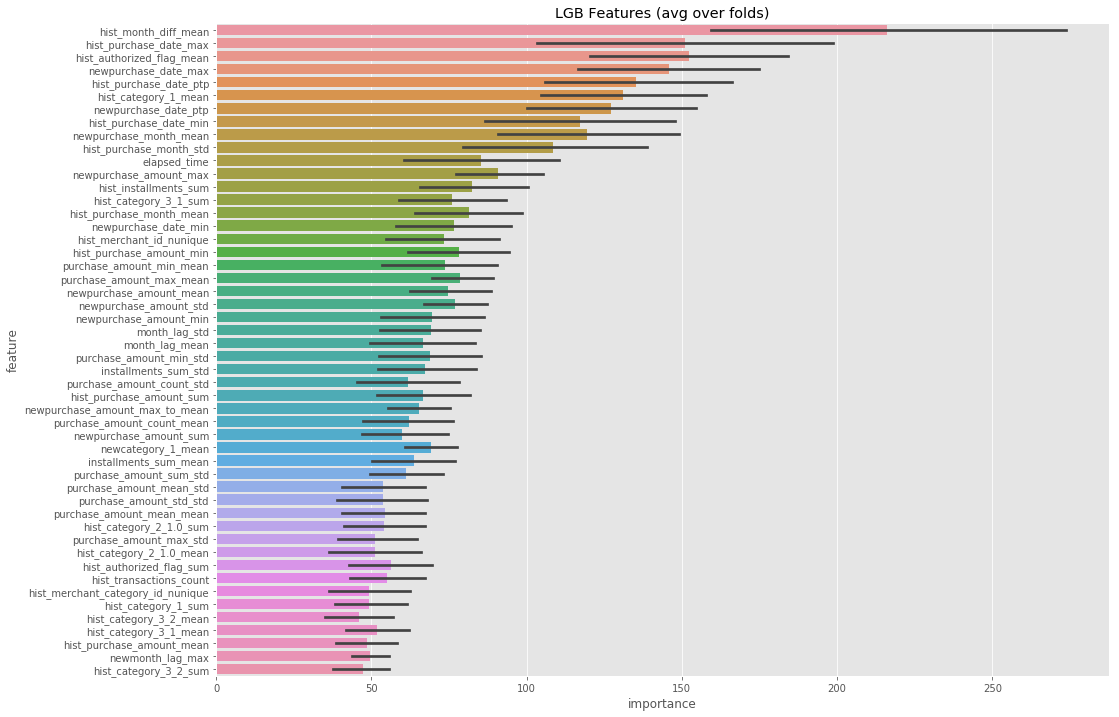

In [107]:
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [109]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = prediction_lgb
submission.to_csv('lightgbm_1225.csv', index=False)

In [110]:
train.head()

,feature_1,feature_2,feature_3,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_time,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_1.0_sum,hist_category_2_2.0_mean,hist_category_2_2.0_sum,hist_category_2_3.0_mean,hist_category_2_3.0_sum,hist_category_2_4.0_mean,hist_category_2_4.0_sum,hist_category_2_5.0_mean,hist_category_2_5.0_sum,hist_category_3_1_sum,hist_category_3_1_mean,hist_category_3_2_sum,hist_category_3_2_mean,hist_category_3_3_sum,hist_category_3_3_mean,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_min,hist_month_lag_max,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,hist_month_diff_min,hist_month_diff_max,hist_month_diff_mean,newtransactions_count,newcategory_1_sum,newcategory_1_mean,newcategory_2_1.0_mean,newcategory_2_1.0_sum,newcategory_2_2.0_mean,newcategory_2_2.0_sum,newcategory_2_3.0_mean,newcategory_2_3.0_sum,newcategory_2_4.0_mean,newcategory_2_4.0_sum,newcategory_2_5.0_mean,newcategory_2_5.0_sum,newcategory_3_1_sum,newcategory_3_1_mean,newcategory_3_2_sum,newcategory_3_2_mean,newcategory_3_3_sum,newcategory_3_3_mean,newmerchant_id_nunique,newpurchase_amount_sum,newpurchase_amount_mean,newpurchase_amount_max,newpurchase_amount_min,newpurchase_amount_std,newinstallments_sum,newinstallments_mean,newinstallments_max,newinstallments_min,newinstallments_std,newpurchase_month_mean,newpurchase_month_max,newpurchase_month_min,newpurchase_month_std,newpurchase_date_ptp,newpurchase_date_max,newpurchase_date_min,newmonth_lag_min,newmonth_lag_max,newmerchant_category_id_nunique,newstate_id_nunique,newsubsector_id_nunique,newcity_id_nunique,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,newpurchase_amount_max_to_mean,newpurchase_date_max_to_mean,purchase_amount_max_mean_to_mean
0,4,1,1,2017,3,6,245,260,247.0,0.950195,260.0,1.000000,0.988281,257.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.011536,3.0,4.0,0.015381,0.0,0.000000,0,0.000000,94,-165.968735,-0.638341,2.258394,-0.739258,0.212139,4,0.015381,1,0,0.123291,8.054688,12,1,3.474609,20977988.0,1.519551e+09,1.498573e+09,-8,0,41,3,21,7,9,11,10.000000,23.0,23.0,1.000000,1.000000,23.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,23.0,-13.242188,-0.575684,-0.296143,-0.724609,0.135742,0.0,0.000000,0.0,0.0,0.000000,3.478516,4.0,3.0,0.510742,4742309.0,1.525001e+09,1.520259e+09,1.0,2.0,14.0,1.0,10.0,3.0,-4.000000,2.738613,28.888889,17.244162,-18.440971,10.472169,-0.650518,0.049922,-0.732686,0.008797,-0.158815,0.916015,0.109641,0.117152,28.888889,17.244162,0.444444,0.726483,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067,2.523438,1.123989,-0.011048
1,3,0,0,2017,6,1,396,350,339.0,0.968750,319.0,0.911621,0.911621,319.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,276.0,0.788574,72.0,0.205688,2,0.005714,142,-210.006332,-0.600018,4.630300,-0.742188,0.384967,543,1.551758,10,-1,1.510742,6.218750,12,1,3.847656,3371768

In [111]:
train.shape

(201917, 127)